In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import NuSVR
#Keras imports
from keras import backend as K

from keras.layers import Input, Dense
from keras.optimizers import RMSprop, SGD, Adagrad,Adam,Adadelta,Adamax,Nadam
from keras.models import Sequential, Model
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam

from time import time

1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


In [33]:
#LINEAR
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

#Guardar en csv columnas desde start hasta en de un dataframe.
def store_column_pd(df,columns_start,columns_end,url):
    temp_df =df.iloc[:,columns_start:columns_end]
    temp_df.to_csv(url)
    return temp_df


In [300]:
K.epsilon()

1e-07

In [34]:
#Data from files
data_algebra = pd.read_csv("/home/dcasals/graph-edit-distance/data/algebra_features.txt")
data_medoids = pd.read_csv("/home/dcasals/graph-edit-distance/data/vectors_medoids.csv")
print(data_algebra.shape,data_medoids.shape)

(19171, 28) (19113, 28)


In [35]:
result = data_algebra.merge(data_medoids,
                 left_on='query_id',right_on='id')
print(result.shape)
result.head()

(19113, 56)


,query_id,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,...,pcs25.16,pcs25.17,pcs25.18,pcs25.19,pcs25.20,pcs25.21,pcs25.22,pcs25.23,pcs25.24,Unnamed: 27_y
0,http://lsq.aksw.org/res/DBpedia-q113812,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.333333,0.500000,0.400000,0.285714,0.200000,0.333333,0.200000,0.200000,NaN
1,http://lsq.aksw.org/res/DBpedia-q113813,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846,NaN
2,http://lsq.aksw.org/res/DBpedia-q113814,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846,NaN
3,http://lsq.aksw.org/res/DBpedia-q113815,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000,NaN
4,http://lsq.aksw.org/res/DBpedia-q113817,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667,NaN


In [36]:
result = result.drop(columns=["query_id","id","Unnamed: 27_x","Unnamed: 27_y"])
result.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'path*', 'pathN*', 'path+', 'pathN+', 'notoneof',
       'tolist', 'order', 'project', 'distinct', 'reduced', 'multi', 'top',
       'group', 'assign', 'sequence', 'slice', 'treesize', 'time', 'pcs25',
       'pcs25.1', 'pcs25.2', 'pcs25.3', 'pcs25.4', 'pcs25.5', 'pcs25.6',
       'pcs25.7', 'pcs25.8', 'pcs25.9', 'pcs25.10', 'pcs25.11', 'pcs25.12',
       'pcs25.13', 'pcs25.14', 'pcs25.15', 'pcs25.16', 'pcs25.17', 'pcs25.18',
       'pcs25.19', 'pcs25.20', 'pcs25.21', 'pcs25.22', 'pcs25.23', 'pcs25.24'],
      dtype='object')

In [37]:
result.describe()

,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,path*,...,pcs25.15,pcs25.16,pcs25.17,pcs25.18,pcs25.19,pcs25.20,pcs25.21,pcs25.22,pcs25.23,pcs25.24
count,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.0,...,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000
mean,2.791817,2.368179,0.067860,0.680322,0.626903,0.200387,0.000314,0.001570,0.000052,0.0,...,0.432244,0.198616,0.366060,0.344247,0.419878,0.306780,0.186979,0.366060,0.223885,0.223885
std,2.424699,2.342441,0.295156,1.206685,1.607434,0.442043,0.017716,0.039588,0.007233,0.0,...,0.213312,0.133551,0.257537,0.109948,0.210350,0.114668,0.028742,0.257537,0.138379,0.138379
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.039216,0.045455,0.042553,0.040000,0.039216,0.042553,0.041667,0.042553,0.045455,0.045455
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.222222,0.133333,0.222222,0.250000,0.222222,0.222222,0.166667,0.222222,0.153846,0.153846
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.400000,0.153846,0.285714,0.400000,0.400000,0.250000,0.200000,0.285714,0.181818,0.181818
75%,4.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.666667,0.200000,0.333333,0.400000,0.666667,0.400000,0.200000,0.333333,0.222222,0.222222
max,36.000000,27.000000,4.000000,21.000000,14.000000,9.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
nunique = result.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
result = result.drop(cols_to_drop, axis=1)
result.shape

Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')


(19113, 42)

In [39]:
new_cols = list(result.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
result.columns = new_cols

In [40]:
result = result[result['time'] < 15000]
X_temp, X_test, y_temp, y_test = train_test_split(
    result.drop(columns=['time']), result['time'], test_size=0.25, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.30, random_state=42,shuffle=True)
print("Shapes : Train: {} Val: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))

Shapes : Train: (9947, 41) Val: (4264, 41), Test: (4737, 41)


In [41]:
X_train.head()

,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,order,...,pcs15,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24
15051,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.153846,0.285714,0.50000,0.400000,0.285714,0.200000,0.285714,0.181818,0.181818
278,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.142857,0.250000,0.40000,0.666667,0.222222,0.166667,0.250000,0.166667,0.166667
13390,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.153846,0.285714,0.50000,0.400000,0.285714,0.200000,0.285714,0.181818,0.181818
17106,4.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.181818,0.400000,0.25000,0.222222,0.400000,0.222222,0.400000,0.222222,0.222222
1225,16.0,16.0,2.0,1.0,12.0,2.0,0.0,0.0,0.0,0.0,...,0.048780,0.058824,0.054054,0.04878,0.048780,0.052632,0.051282,0.054054,0.057143,0.057143


In [42]:
#Standarizar
scalerx = StandardScaler()
x_train_scaled = scalerx.fit_transform(X_train);
x_val_scaled = scalerx.transform(X_val);
x_test_scaled = scalerx.fit_transform(X_test);

scaled_df_train = pd.DataFrame(x_train_scaled, index=X_train.index, columns=X_train.columns)
scaled_df_val = pd.DataFrame(x_val_scaled, index=X_val.index, columns=X_train.columns)
scaled_df_test = pd.DataFrame(x_test_scaled, index=X_test.index, columns=X_train.columns)

In [43]:
#Save data
scaled_df_train.join(y_train).to_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv", index=False)
scaled_df_val.join(y_val).to_csv("/home/dcasals/jupyter/mlproject/xval_std.csv", index=False)
scaled_df_test.join(y_test).to_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv", index=False)

In [367]:
#READ data
scaled_df_train = pd.read_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv")
scaled_df_val   = pd.read_csv("/home/dcasals/jupyter/mlproject/xval_std.csv")
scaled_df_test  = pd.read_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv")

y_train = scaled_df_train['time']
y_val   = scaled_df_val['time']
y_test  = scaled_df_test['time']
scaled_df_train = scaled_df_train.drop(columns=['time'])
scaled_df_val = scaled_df_val.drop(columns=['time'])
scaled_df_test = scaled_df_test.drop(columns=['time'])

In [368]:
scaled_df_train = scaled_df_train[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_val = scaled_df_val[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_test = scaled_df_test[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_train.shape,scaled_df_val.shape,scaled_df_test.shape

((9947, 34), (4264, 34), (4737, 34))

In [48]:
scaled_df_train.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [369]:
#Pass Target to log scale
y_train_log = np.log(y_train.values.reshape(-1, 1))
y_val_log = np.log(y_val.values.reshape(-1, 1))
y_test_log = np.log(y_test.values.reshape(-1, 1))

#Standarizar target
scalery = StandardScaler()
y_train_log_std = scalery.fit_transform(y_train_log)
y_val_log_std = scalery.transform(y_val_log)
y_test_log_std = scalery.transform(y_test_log)

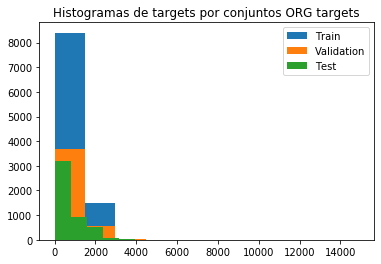

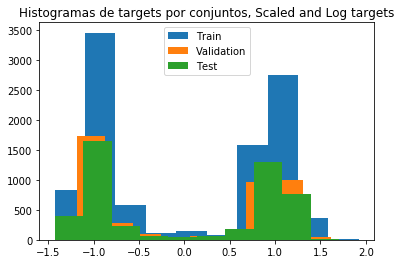

In [50]:
plt.title("Histogramas de targets por conjuntos ORG targets")
plt.hist(y_train.values.reshape(-1, 1),label="Train")
plt.hist(y_val.values.reshape(-1, 1),label="Validation")
plt.hist(y_test.values.reshape(-1, 1),label="Test")
plt.legend()
plt.show()
plt.title("Histogramas de targets por conjuntos, Scaled and Log targets")
plt.hist(y_train_log_std,label="Train")
plt.hist(y_val_log_std,label="Validation")
plt.hist(y_test_log_std,label="Test")
plt.legend()
plt.show()

<span style="color:blue">

### Entrenando RNN. Primer enfoque

- Datos escalados
- Targets escalados y en escala logarítmica.


In [63]:
# Set callback functions to early stop training and save the best model so far
from sklearn.metrics import r2_score

def tune_params(dftable, x_train, y_train,x_val, y_val, scalery, n1, n2, n3, epochs, optimizer, dropout):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.hdf5',
                                      monitor='val_loss', save_best_only=True
                                     )
    ]

    model = Sequential()
    model.add(Dense(n1, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history_org = model.fit(x_train.values, y_train,
        epochs=epochs,
        batch_size=120,
        validation_data=(x_val.values, y_val),
        callbacks=callbacks_best,
        verbose=False
    )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    timeconsume = round(t1-t0,3)
    print("training time {}",format(timeconsume))
    print("Saved model to disk")
    return [model, history_org, dftable, timeconsume]


In [68]:
import random
optimizer=Adam(learning_rate=0.00015)
epochs=450
dropout=0.25
max_r2=0
min_rmse=10000
dftable = pd.DataFrame(columns=[])
best_l1 = 1
best_l2 = 1
best_l3 = 1
dataout = []
for idx,item in enumerate(list(range(1,15))):
    n1 = random.randrange(260,300,20)
    n2 = random.randrange(300,350,20)
    n3 = random.randrange(200,300,20)
    model_trained = tune_params(dftable, scaled_df_train, y_train_log_std, scaled_df_val, y_val_log_std, scalery, n1,n2,n3,epochs,optimizer,dropout)
    dataout.append(model_trained)
    dftable = model_trained[2]
    y_pred_train = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_train).reshape(-1, 1)))
    y_pred_val = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_val).reshape(-1, 1)))
    y_pred_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test).reshape(-1, 1)))
            
    current_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    if current_rmse < min_rmse:
        best_l1 = n1
        best_l2 = n2
        best_l3 = n3

        min_rmse = current_rmse
        mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mse_val  =  np.sqrt(mean_squared_error(y_val, y_pred_val))
        mse_test =  np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_train = r2_score(y_train, y_pred_train)
        r2_val  =  r2_score( y_val, y_pred_val)
        r2_test =  r2_score(y_test, y_pred_test)

        dftable = dftable.append(pd.Series([n1, n2, n3, mse_train, mse_val, mse_test,r2_train, r2_val,r2_test]), ignore_index=True)
        print("RMSE Train",n1, n2, n3, mse_train)
        print("RMSE VAL  ",n1, n2, n3, mse_val)
        print("RMSE TEST ",n1, n2, n3, mse_test)
        print("R2 Train",  n1, n2, n3, r2_train)
        print("R2 VAL  ",  n1, n2, n3, r2_val)
        print("R2 TEST ",  n1, n2, n3, r2_test)
        print("____________________")
dftable

before train: Init time: 1583871710.921
after train, finish time: 1583871905.999
training time {} 195.078
Saved model to disk
RMSE Train 280 340 280 667.7249945703904
RMSE VAL   280 340 280 613.5407668536627
RMSE TEST  280 340 280 515.5052165274504
R2 Train 280 340 280 0.4332059370502368
R2 VAL   280 340 280 0.4344834024402474
R2 TEST  280 340 280 0.5279366276735211
____________________
before train: Init time: 1583871906.854
after train, finish time: 1583872126.999
training time {} 220.146
Saved model to disk
RMSE Train 280 320 240 641.5687891946544
RMSE VAL   280 320 240 591.4365570659859
RMSE TEST  280 320 240 491.1443724812426
R2 Train 280 320 240 0.47674127004623046
R2 VAL   280 320 240 0.4744974398636618
R2 TEST  280 320 240 0.571498328484576
____________________
before train: Init time: 1583872127.796
after train, finish time: 1583872286.228
training time {} 158.432
Saved model to disk
before train: Init time: 1583872287.027
after train, finish time: 1583872538.717
training time

,0,1,2,3,4,5,6,7,8
0,280.0,340.0,280.0,667.724995,613.540767,515.505217,0.433206,0.434483,0.527937
1,280.0,320.0,240.0,641.568789,591.436557,491.144372,0.476741,0.474497,0.571498
2,260.0,300.0,240.0,628.109825,584.303888,481.832513,0.498465,0.487096,0.587593


In [62]:
y_pred = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_val = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_val.values).reshape(-1, 1)))

r2_train = r2_score(y_train, y_pred)
r2_val  =  r2_score( y_val, y_pred_val)
r2_train,r2_val

(0.47419900477928645, 0.4733220472796885)

In [71]:
dftable

,Layer1,Layer2,Layer3,MSE_TRAIN,MES_VAL,MSE_TEST,R2_TRAIN,R2_VAL,R2_TEST
0,280.0,340.0,280.0,667.724995,613.540767,515.505217,0.433206,0.434483,0.527937
1,280.0,320.0,240.0,641.568789,591.436557,491.144372,0.476741,0.474497,0.571498
2,260.0,300.0,240.0,628.109825,584.303888,481.832513,0.498465,0.487096,0.587593


In [72]:
dftable.columns = ['Layer1','Layer2','Layer3', 'MSE_TRAIN', 'MES_VAL','MSE_TEST','R2_TRAIN', 'R2_VAL','R2_TEST']
print(dftable[['Layer1','Layer2','Layer3', 'MSE_TRAIN', 'MES_VAL','R2_TRAIN', 'R2_VAL']].sort_values('MES_VAL', axis=0,ascii).to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 Layer1 &  Layer2 &  Layer3 &   MSE\_TRAIN &     MES\_VAL &  R2\_TRAIN &    R2\_VAL \\
\midrule
  260.0 &   300.0 &   240.0 &  628.109825 &  584.303888 &  0.498465 &  0.487096 \\
  280.0 &   320.0 &   240.0 &  641.568789 &  591.436557 &  0.476741 &  0.474497 \\
  280.0 &   340.0 &   280.0 &  667.724995 &  613.540767 &  0.433206 &  0.434483 \\
\bottomrule
\end{tabular}



before train: Init time: 1573612137.386
Train on 9947 samples, validate on 4264 samples
Epoch 1/500
9947/9947 [==============================] - 1s 121us/step - loss: 0.5256 - mae: 0.5827 - coeff_determination: 0.4710 - rmse: 2.0071 - val_loss: 0.3379 - val_mae: 0.3864 - val_coeff_determination: 0.6546 - val_rmse: 1.6623
Epoch 2/500
9947/9947 [==============================] - 1s 82us/step - loss: 0.3793 - mae: 0.4590 - coeff_determination: 0.6176 - rmse: 1.7574 - val_loss: 0.2978 - val_mae: 0.3185 - val_coeff_determination: 0.6955 - val_rmse: 1.5762
Epoch 3/500
9947/9947 [==============================] - 1s 84us/step - loss: 0.3430 - mae: 0.4180 - coeff_determination: 0.6539 - rmse: 1.6940 - val_loss: 0.2879 - val_mae: 0.3290 - val_coeff_determination: 0.7058 - val_rmse: 1.5739
Epoch 4/500
9947/9947 [==============================] - 1s 86us/step - loss: 0.3307 - mae: 0.4012 - coeff_determination: 0.6670 - rmse: 1.7801 - val_loss: 0.2753 - val_mae: 0.3137 - val_coeff_determination: 0

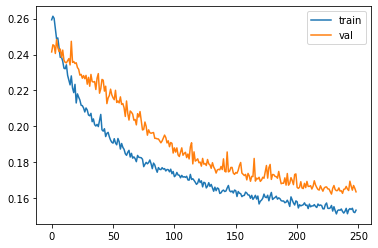

In [230]:
n1=280
n2=320
n3=280
epochs=500
dropout=0.30
optimizer=Adam(learning_rate=0.00015)
model_trained = tune_params(dftable, scaled_df_train,y_train_log_std, scaled_df_val, y_val_log_std,scalery, n1,n2,n3,epochs,optimizer,dropout)
plt.plot(model_trained[1].history['loss'][13:],label="train")
plt.plot(model_trained[1].history['val_loss'][13:],label="val")
plt.legend()
plt.show()
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval

In [55]:
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval


489.9161049543266

In [59]:
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_train.values).reshape(-1, 1)))
rmseval = r2_score(y_train,y_pred_org_test)
rmseval

0.47419900477928645

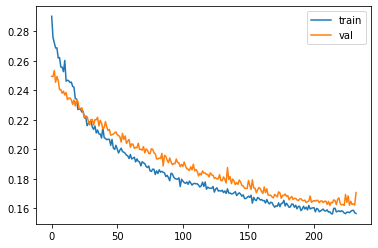

In [116]:
history_org = model_trained[1] 
model = model_trained[0]
#Prediction
y_pred_org_train = np.exp(scalery.inverse_transform(model.predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(model.predict(scaled_df_val.values).reshape(-1, 1)))

rmse_train = np.sqrt(mean_squared_error(y_pred_org_train, y_train))
rmseval = np.sqrt(mean_squared_error(y_pred_org_val, y_val))
plt.plot(history_org.history['loss'][13:],label="train")
plt.plot(history_org.history['val_loss'][13:],label="val")
plt.legend()
plt.show()


In [118]:
#Imprimir la  predicción en conjunto de validación
a = y_pred_org_val.reshape(1, -1)
for i in range(y_val.shape[0]):
#     print(y_val[i])
    print("%10.3f,  %10.3f"%(a[0][i],y_val.values[i]))

     3.160,       3.000
   617.584,     586.000
     4.193,       3.000
     4.437,       4.000
     3.116,       9.000
   816.014,    1192.000
     4.437,       4.000
     4.437,       4.000
     4.437,       4.000
  1243.222,    1216.000
     9.825,       3.000
   895.329,    1217.000
     4.437,       4.000
    12.489,      10.000
    17.731,       8.000
  1050.817,    1468.000
  1475.557,    2006.000
     3.437,       2.000
    89.052,    1169.000
   866.542,    1184.000
     4.437,       4.000
     2.370,       3.000
   952.031,    1322.000
     4.437,       4.000
     3.561,       3.000
   895.329,     829.000
   188.641,     661.000
   895.329,     945.000
     3.160,       3.000
     4.437,       3.000
     3.561,       2.000
    17.731,    2410.000
   949.041,    1250.000
   895.329,    1238.000
     4.437,       4.000
     4.437,       4.000
    99.146,     130.000
     9.197,    1094.000
   796.891,    1531.000
  1198.447,    1807.000
   981.990,    1028.000
  1095.338,    2

In [236]:
y_pred_org_test = np.exp(scalery.inverse_transform(model.predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval

500.39266779825715

### Update, columnas originales del paper.


In [8]:
scaled_df_train.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [12]:
scaled_df_train = scaled_df_train[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_val = scaled_df_val[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_test = scaled_df_test[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_train.shape,scaled_df_val.shape,scaled_df_test.shape

((9947, 34), (4264, 34), (4737, 34))

In [ ]:
n1=280
n2=320
n3=280
epochs=500
dropout=0.30
optimizer=Adam(learning_rate=0.00015)
model_trained = tune_params(dftable, scaled_df_train,y_train_log_std, scaled_df_val, y_val_log_std,scalery, n1,n2,n3,epochs,optimizer,dropout)
plt.plot(model_trained[1].history['loss'][13:],label="train")
plt.plot(model_trained[1].history['val_loss'][13:],label="val")
plt.legend()
plt.show()
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval

In [142]:
def train_autoencoder(x_train, x_val,encoding_dim,verbose):
    # Set callback functions to early stop training and save the best model so far
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=10),
                ]
    # def autoencode_pd(df):
    # this is the size of our encoded representations
    # this is our input placeholder
    input_img = Input(shape=(x_train.shape[1],))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x_train.shape[1], activation='linear')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer=Nadam(learning_rate=0.0001), loss='mse')
    print(autoencoder.summary())
    autoencoder.fit(x_train, x_train,
                    epochs=300,
             batch_size=120,
                    shuffle=True,
                    validation_data=(x_val, x_val),
                    verbose=verbose,
                    callbacks=callbacks_best)
    return autoencoder

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 34)                0         
_________________________________________________________________
dense_181 (Dense)            (None, 20)                700       
_________________________________________________________________
dense_182 (Dense)            (None, 34)                714       
Total params: 1,414
Trainable params: 1,414
Non-trainable params: 0
_________________________________________________________________
None


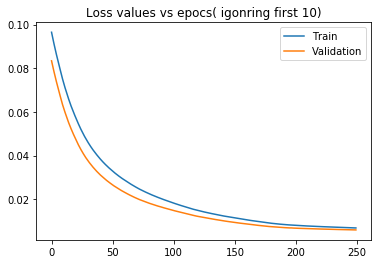

In [143]:
autoencoder = train_autoencoder(scaled_df_train, scaled_df_val, 20,verbose=False)
plt.plot(autoencoder.history.history['loss'][50:],label="Train")
plt.plot(autoencoder.history.history['val_loss'][50:],label="Validation")
plt.title("Loss values vs epocs( igonring first 10)")
plt.legend()
plt.show()

In [144]:
autoencoder.save("autoencoder_newdata.h5")
# encoder.save("encoder.h5")

In [79]:
best_l1 , best_l2, best_l3

(260, 300, 240)

In [145]:
# Set callback functions to early stop training and save the best model so far
def tune_params_autoencoder(autoencoder, x_train, y_train, x_val, y_val, n1, n2, n3, scalery, epochs, optimizer, dropout):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(autoencoder.layers[0])
    model.add(autoencoder.layers[1])
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history_org = model.fit(x_train.values, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val.values, y_val),
                    callbacks=callbacks_best,
                    verbose=False
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    #Prediction
    y_pred_org_train = np.exp(scalery.inverse_transform(model.predict(x_train.values).reshape(-1, 1)))
    y_pred_org_val = np.exp(scalery.inverse_transform(model.predict(x_val.values).reshape(-1, 1)))

    rmse_train = np.sqrt(mean_squared_error(y_pred_org_train, y_train))
    rmseval = np.sqrt(mean_squared_error(y_pred_org_val, y_val))
    
    print("RMSE Train", np.sqrt(mean_squared_error(y_train, y_pred_org_train)))
    print("RMSE VAL", np.sqrt(mean_squared_error(y_val, y_pred_org_val)))
    print("R2 Train", r2_score(y_train, y_pred_org_train))
    print("R2 VAL", r2_score(y_val, y_pred_org_val))
    # serialize model to JSON
#     model_json = model.to_json()
#     optim_name= str(optimizer).split(".")[2].split(" ")[0]
#     with open("/home/dcasals/jupyter/mlproject/models/model_"+"_".join(["autoencoder", str(int(rmseval)), optim_name, str(n1),str(n2),str(n3),str(epochs),str(dropout)])+".json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights("model.h5")
    return [model, history_org, round(t1-t0, 3)]

### Aplicación del modelo respecto al entrenamiento de un autoencoder como parte inicial del modelo.

In [146]:
epochs=450
dropout=0.25
optimizer=Adam(learning_rate=0.00015)
model_trained_aenc = tune_params_autoencoder(
    autoencoder,
    scaled_df_train,
    y_train_log_std,
    scaled_df_val,
    y_val_log_std,
    best_l1 , 
    best_l2, 
    best_l3,
    scalery,
    epochs,
    optimizer,
    dropout)

y_pred_org_test = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_test, y_pred_org_test ))
r2val = r2_score(y_test, y_pred_org_test )

print("MSE:{} y R2: {}".format(rmseval, r2val))

before train: Init time: 1583932643.991
after train, finish time: 1583932990.269
training time {} 346.278
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 20)                700       
_________________________________________________________________
dense_183 (Dense)            (None, 260)               5460      
_________________________________________________________________
dropout_89 (Dropout)         (None, 260)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 300)               78300     
_________________________________________________________________
dropout_90 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_185 (Dense)            (None, 240)               72240     
_____________

In [150]:
def loadModel(autoencoder,url):
    model = Sequential()
    model.add(autoencoder.layers[0])
    model.add(autoencoder.layers[1])
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.load_weights(url)
    return model

In [157]:
y_pred_org_train = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_val.values).reshape(-1, 1)))
r2val = r2_score(y_val, y_pred_org_val)
r2train = r2_score(y_train, y_pred_org_train)
r2val, r2train

(0.4991682905595566, 0.5090656402492925)

In [295]:
def MSE_data(model, x_datasub, y_truesub):
    y_pred = np.exp(scalery.inverse_transform(model.predict(x_datasub.values).reshape(-1, 1)))
    rmse = np.sqrt(mean_squared_error(y_truesub, y_pred.flatten()))
    return rmse
def r2score_data(model, x_datasub, y_truesub):
    y_pred = np.exp(scalery.inverse_transform(model.predict(x_datasub.values).reshape(-1, 1)))
    r2 = r2_score(y_truesub, y_pred.flatten())
    return r2
def print_predictions(model, x_datasub, y_truesub):
    y_pred = np.exp(scalery.inverse_transform(model.predict(x_datasub.values).reshape(-1, 1)))
    return list(zip(y_truesub, y_pred.flatten()))

def metrics_and_predMin20(model, x_data, y_trueva):
    sub_y_true = y_trueva[y_trueva < 21]
    data = scaled_df_test.loc[sub_y_true.index]
    print("MSE ",MSE_data(model, data, sub_y_true))
    print("R2 ",r2score_data(model, data, sub_y_true))
    print("Puntos: {}".format(data.shape))
    allv = print_predictions(model, data, sub_y_true)
    plt.scatter([a[0]for a in allv],[a[1] for a in allv])
    plt.ylim(0, 25)
    plt.show()
    plt.plot([a[0]for a in allv[:100]],label="true")
    plt.plot([a[1] for a in allv[:100]],label="pred")
    plt.ylim(0,25)
    plt.legend()
    plt.show()
    plt.plot(np.sort([a[0]for a in allv]))
    plt.plot(np.sort([a[1] for a in allv]))
    plt.ylim(0,25)
    plt.show()
    for val in allv[:50]:
        print(val)
def metrics_and_predMin100(model, x_data, y_trueva):
    sub_y_true = y_trueva[y_trueva < 100]
    data = scaled_df_test.loc[sub_y_true.index]
    print("MSE ",MSE_data(model, data, sub_y_true))
    print("R2 ",r2score_data(model, data, sub_y_true))
    allv = print_predictions(model, data, sub_y_true)
    plt.scatter([a[0]for a in allv],[a[1] for a in allv])
    plt.ylim(0,100)
    plt.show()
    plt.plot([a[0]for a in allv],[a[1] for a in allv])
    plt.show()
    for val in allv[:50]:
        print(val)
def metrics_and_pred20_100(model, x_data, y_trueva):
    sub_y_true = y_trueva[(y_trueva > 20) & (y_trueva < 100)]
    data = scaled_df_test.loc[sub_y_true.index]
    print("MSE ",MSE_data(model, data, sub_y_true))
    print("R2 ",r2score_data(model, data, sub_y_true))
    allv = print_predictions(model, data, sub_y_true)
    plt.scatter([a[0]for a in allv],[a[1] for a in allv])
    plt.ylim(0,120)
    plt.show()
    for val in allv[:50]:
        print(val)

def metrics_and_predMas100Menos1000(model, x_data, y_trueva):
    sub_y_true = y_trueva[(y_trueva > 100) & (y_trueva < 1000)]
    data = scaled_df_test.loc[sub_y_true.index]
    print("MSE ",MSE_data(model, data, sub_y_true))
    print("R2 ",r2score_data(model, data, sub_y_true))
    allv = print_predictions(model, data, sub_y_true)
    plt.scatter([a[0]for a in allv],[a[1] for a in allv])
    plt.ylim(0,1200)
    plt.show()
    for val in allv[:50]:
        print(val)
        
def metrics_and_predMas1000(model, x_data, y_trueva):
    sub_y_true = y_trueva[y_trueva > 1000]
    data = scaled_df_test.loc[sub_y_true.index]
    print("MSE ",MSE_data(model, data, sub_y_true))
    print("R2 ",r2score_data(model, data, sub_y_true))
    allv = print_predictions(model, data, sub_y_true)
    for val in allv[:50]:
        print(val)

In [171]:
# r2score_data(model_trained_aenc[0],scaled_df_test,y_test.values)
y_testminor100 = y_test[y_test < 100]

In [186]:
x_testminor100  = scaled_df_test.loc[y_testminor100.index]
x_testminor100.shape,y_testminor100.shape

((2417, 34), (2417,))

MSE  89.6812714925442
R2  -1147.1245689761747
Puntos: (2313, 34)


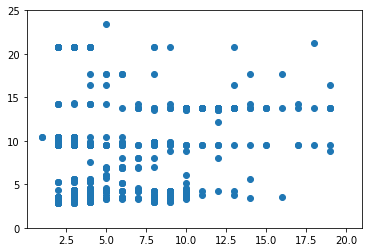

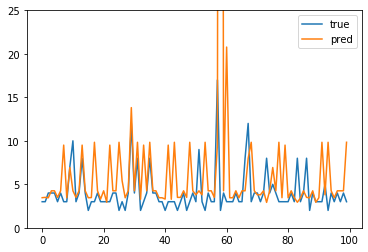

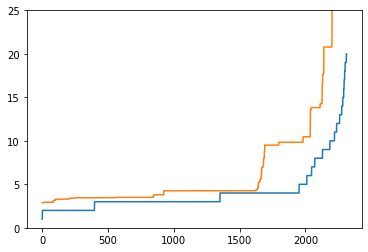

(3, 3.462738)
(3, 3.498629)
(4, 3.4538438)
(4, 4.253162)
(4, 4.253162)
(3, 3.498629)
(4, 4.253162)
(3, 9.507286)
(3, 3.4538438)
(7, 6.932267)
(10, 4.253162)
(3, 3.498629)
(4, 4.253162)
(8, 9.507286)
(4, 4.253162)
(2, 3.4538438)
(3, 3.4756153)
(3, 9.833519)
(4, 4.253162)
(3, 3.3014414)
(3, 4.253162)
(3, 2.937273)
(3, 9.507286)
(4, 4.253162)
(4, 4.253162)
(2, 9.833519)
(3, 5.41531)
(2, 3.4538438)
(4, 4.253162)
(12, 13.818784)
(4, 4.253162)
(8, 9.833519)
(2, 3.2790961)
(3, 9.507286)
(4, 4.253162)
(8, 9.833519)
(4, 4.253162)
(4, 4.253162)
(3, 3.4538438)
(3, 3.4538438)
(2, 3.3048427)
(3, 9.507286)
(3, 3.2790961)
(3, 9.833519)
(2, 3.498629)
(3, 3.498629)
(4, 4.253162)
(2, 3.498629)
(3, 9.833519)
(4, 4.253162)


In [296]:
metrics_and_predMin20(model_trained_aenc[0],scaled_df_test, y_test)

MSE  92.70943039590539
R2  -69.37878240638052


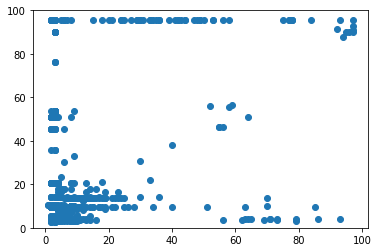

(3, 3.462738)
(3, 3.498629)
(4, 3.4538438)
(4, 4.253162)
(4, 4.253162)
(3, 3.498629)
(4, 4.253162)
(3, 9.507286)
(3, 3.4538438)
(7, 6.932267)
(10, 4.253162)
(3, 3.498629)
(4, 4.253162)
(8, 9.507286)
(4, 4.253162)
(2, 3.4538438)
(3, 3.4756153)
(3, 9.833519)
(4, 4.253162)
(3, 3.3014414)
(3, 4.253162)
(3, 2.937273)
(3, 9.507286)
(4, 4.253162)
(4, 4.253162)
(2, 9.833519)
(3, 5.41531)
(2, 3.4538438)
(4, 4.253162)
(12, 13.818784)
(4, 4.253162)
(8, 9.833519)
(2, 3.2790961)
(3, 9.507286)
(4, 4.253162)
(8, 9.833519)
(4, 4.253162)
(4, 4.253162)
(3, 3.4538438)
(3, 3.4538438)
(2, 3.3048427)
(3, 9.507286)
(3, 3.2790961)
(3, 9.833519)
(2, 3.498629)
(3, 3.498629)
(4, 4.253162)
(2, 3.498629)
(3, 9.833519)
(4, 4.253162)


In [275]:
#Prediction with y_true in [0:100]
metrics_and_predMin100(model_trained_aenc[0],scaled_df_test, y_test)

MSE  144.4942263494342
R2  -38.06103423568481


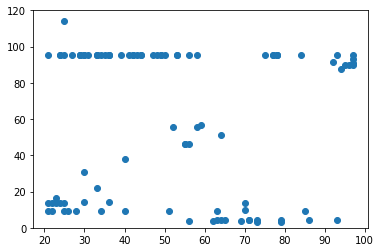

(51, 9.507286)
(36, 95.60613)
(41, 95.60613)
(78, 95.60613)
(77, 95.60613)
(34, 95.60613)
(92, 91.346664)
(73, 4.253162)
(22, 13.818784)
(50, 408.87894)
(25, 113.970535)
(65, 410.00604)
(71, 4.253162)
(47, 95.60613)
(71, 4.253162)
(26, 9.507286)
(64, 4.253162)
(62, 3.498629)
(30, 14.255991)
(39, 95.60613)
(79, 3.3151517)
(69, 3.498629)
(29, 95.60613)
(24, 95.60613)
(55, 46.158157)
(95, 89.91542)
(25, 13.818784)
(93, 4.253162)
(36, 95.60613)
(28, 9.507286)
(48, 95.60613)
(25, 95.60613)
(26, 164.69283)
(93, 95.60613)
(64, 50.99571)
(49, 95.60613)
(33, 95.60613)
(30, 95.60613)
(97, 92.99392)
(21, 9.507286)
(79, 4.264022)
(23, 13.818784)
(58, 55.63238)
(96, 89.97594)
(97, 91.1733)
(37, 788.3562)
(44, 95.60613)
(94, 87.55713)
(52, 55.812798)
(23, 14.255991)


In [279]:
metrics_and_pred20_100(model_trained_aenc[0],scaled_df_test, y_test)

MSE  351.5183945294726
R2  -2.3428845344959317


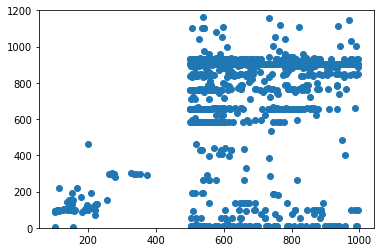

(651, 902.3433)
(151, 151.23856)
(542, 657.0099)
(595, 657.0099)
(935, 9.833519)
(788, 902.3433)
(539, 584.2633)
(169, 219.41481)
(880, 764.01105)
(735, 1290.641)
(959, 402.2256)
(518, 584.2633)
(629, 848.93066)
(863, 835.84656)
(201, 104.774376)
(726, 10.466282)
(981, 1290.641)
(776, 844.82745)
(708, 859.2194)
(123, 98.122055)
(887, 1326.6605)
(856, 663.2088)
(270, 300.17358)
(863, 930.53986)
(835, 959.0598)
(805, 1290.641)
(869, 657.0099)
(899, 9.833519)
(651, 848.93066)
(112, 97.86557)
(837, 902.3433)
(604, 793.7074)
(865, 935.77527)
(549, 584.2633)
(545, 657.0099)
(849, 1614.4386)
(851, 848.93066)
(129, 103.507706)
(578, 1290.641)
(712, 1290.641)
(761, 179.13708)
(958, 902.3433)
(789, 902.3433)
(899, 1290.641)
(666, 3.3151517)
(977, 1290.641)
(721, 902.3433)
(103, 92.916306)
(558, 932.06836)
(141, 95.60613)


In [280]:
#Prediction with y_true in [101: 1000]
metrics_and_predMas100Menos1000(model_trained_aenc[0],scaled_df_test, y_test)

In [235]:
metrics_and_predMas1000(model_trained_aenc[0],scaled_df_test, y_test)

MSE  872.1346768177135
R2  -1.2500601150045294
(1111, 23.412119)
(1274, 1290.641)
(1158, 1290.641)
(2318, 1427.2285)
(1165, 1290.641)
(1864, 1290.641)
(1495, 1290.641)
(1362, 1427.2285)
(2008, 1290.641)
(1192, 1032.7993)
(2137, 830.63574)
(1264, 1290.641)
(1021, 9.833519)
(2008, 1290.641)
(1627, 930.53986)
(3084, 1427.2285)
(1767, 1290.641)
(1125, 848.93066)
(1211, 1290.641)
(2090, 1290.641)
(2020, 1290.641)
(1242, 1290.641)
(1079, 1427.2285)
(1574, 9.507286)
(1205, 788.3562)
(1430, 1290.641)
(2428, 1427.2285)
(1648, 902.3433)
(1791, 1290.641)
(2007, 1500.1726)
(2004, 238.44434)
(2138, 1290.641)
(1866, 848.93066)
(1564, 1290.641)
(1034, 1427.2285)
(1366, 1290.641)
(1401, 902.3433)
(1343, 1290.641)
(1743, 1290.641)
(1855, 1290.641)
(2009, 1500.1726)
(1297, 902.3433)
(1207, 696.4847)
(2008, 1290.641)
(1629, 1290.641)
(1245, 902.3433)
(1890, 584.2633)
(1323, 902.3433)
(1635, 1500.1726)
(1663, 1290.641)


In [214]:
print(y_test[(y_test > 100) & (y_test < 1000)])

1       651
3       151
6       542
13      595
15      935
       ... 
4715    835
4718    820
4720    617
4729    526
4736    623
Name: time, Length: 1129, dtype: int64


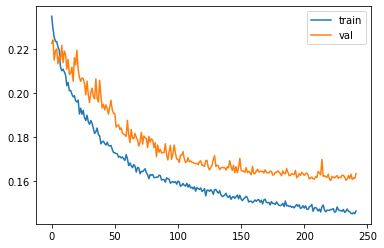

In [90]:
history_org_enc = model_trained_aenc[1] 
model_trained_aenc = model_trained_aenc[0]
#Prediction
y_pred_org_train = np.exp(scalery.inverse_transform(model_trained_aenc.predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(model_trained_aenc.predict(scaled_df_val.values).reshape(-1, 1)))

rmse_train = np.sqrt(mean_squared_error(y_pred_org_train, y_train))
rmseval = np.sqrt(mean_squared_error(y_pred_org_val, y_val))
plt.plot(history_org_enc.history['loss'][13:],label="train")
plt.plot(history_org_enc.history['val_loss'][13:],label="val")
plt.legend()
plt.show()

**Baseline, SVR con datos nuevos.**

Se entrena una Nu-SVR tal como propone el paper original con los datos nuevos.

In [109]:
def baseline_svr(C,nu,dftable):
    
    sv = NuSVR(C=C, nu=nu)

    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))

    sv.fit(scaled_df_train.values, y_train_log_std)
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0,3)))
    y_train_hat_svr = scalery.inverse_transform(sv.predict(scaled_df_train.values).reshape(-1, 1))
    y_val_hat_svr = scalery.inverse_transform(sv.predict(scaled_df_val.values).reshape(-1, 1))
    y_test_hat_svr = scalery.inverse_transform(sv.predict(scaled_df_test.values).reshape(-1, 1))

    #MSE for valid
    mse_svr_curr = np.sqrt(mean_squared_error(y_train_hat_svr,y_train))
    mse_svr_val_curr = np.sqrt(mean_squared_error(y_val_hat_svr,y_val))
    mse_svr_test_curr = np.sqrt(mean_squared_error(y_test_hat_svr,y_test))

    scores_train_curr = sv.score(scaled_df_train.values, y_train_log_std)
    scores_val_curr = sv.score(scaled_df_val.values,   y_val_log_std)
    scores_test_curr = sv.score(scaled_df_test,   y_test_log_std)

    print("MSE val: {}, MSE train {}, R2 val:{}, R2 train:{}".format(mse_svr_val_curr,mse_svr_curr,scores_val_curr,scores_train_curr))
    print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr, scores_test_curr))
    dftable = dftable.append(pd.Series([
                                C, nu, mse_svr_curr, mse_svr_val_curr, mse_svr_test_curr,
                                scores_train_curr, scores_val_curr, scores_test_curr,
                                round(t1-t0,3)]), ignore_index=True
                            )
    return sv, dftable

In [110]:
result_baseline_model = []
dftable = pd.DataFrame(columns=[])
for i in range(1,20):
    C = random.randrange(100,350,20)
    nu = random.randrange(10,50,5)/100
    result_baseline_model
    sv,dftable = baseline_svr(C, nu, dftable)
    result_baseline_model.append(sv)

before train: Init time: 1583894152.191


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583894480.145
training time {} 327.954
MSE val: 1004.0571175546609, MSE train 1074.339894094758, R2 val:0.7925011675395424, R2 train:0.8233529809500915
MSE test: 946.3698924089566, R2 test:0.7965065475294482
before train: Init time: 1583894490.387


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583895090.057
training time {} 599.67
MSE val: 1004.0556755283583, MSE train 1074.3373965209528, R2 val:0.7891793161847848, R2 train:0.8189938051826067
MSE test: 946.3728333615903, R2 test:0.7943099634501964
before train: Init time: 1583895103.754


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583895612.592
training time {} 508.838
MSE val: 1004.0463646731863, MSE train 1074.3299492638444, R2 val:0.7864666251683123, R2 train:0.815260431702307
MSE test: 946.3712290644099, R2 test:0.7906938688059327
before train: Init time: 1583895629.58


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583895858.05
training time {} 228.47
MSE val: 1004.0540995468958, MSE train 1074.3429201984698, R2 val:0.7891333908461872, R2 train:0.8141050379602623
MSE test: 946.360899737424, R2 test:0.7953604887948377
before train: Init time: 1583895873.33


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583896055.257
training time {} 181.926
MSE val: 1004.0616596881894, MSE train 1074.3475024154682, R2 val:0.7942842805579386, R2 train:0.8218254171712244
MSE test: 946.365223094564, R2 test:0.799761169200568
before train: Init time: 1583896065.426


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583896239.684
training time {} 174.258
MSE val: 1004.0676442646518, MSE train 1074.3554854662918, R2 val:0.7959957009186458, R2 train:0.8221901651777459
MSE test: 946.3635112910029, R2 test:0.8017888046700131
before train: Init time: 1583896248.064


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583896274.516
training time {} 26.452
MSE val: 1004.1822220802038, MSE train 1074.489551640617, R2 val:0.7330101177037602, R2 train:0.7470291380033414
MSE test: 946.4733324499191, R2 test:0.7436490632565587
before train: Init time: 1583896278.936


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583896307.532
training time {} 28.596
MSE val: 1004.176239079989, MSE train 1074.483650638011, R2 val:0.7364548147294694, R2 train:0.7506949261469614
MSE test: 946.4705812397909, R2 test:0.7462753159001743
before train: Init time: 1583896312.033


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583896383.225
training time {} 71.192
MSE val: 1004.1889910882903, MSE train 1074.4911651403145, R2 val:0.7483187943770871, R2 train:0.764410723418615
MSE test: 946.4785271625627, R2 test:0.7547977348331287
before train: Init time: 1583896387.876


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583896459.161
training time {} 71.285
MSE val: 1004.1889910882903, MSE train 1074.4911651403145, R2 val:0.7483187943770871, R2 train:0.764410723418615
MSE test: 946.4785271625627, R2 test:0.7547977348331287
before train: Init time: 1583896463.817


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583897168.915
training time {} 705.098
MSE val: 1004.0431275960848, MSE train 1074.3221578274693, R2 val:0.7848145202720405, R2 train:0.8162381474069358
MSE test: 946.3735818320168, R2 test:0.7895112761069717
before train: Init time: 1583897186.012


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583897291.722
training time {} 105.71
MSE val: 1004.0753705043489, MSE train 1074.3650091844272, R2 val:0.7955971206653645, R2 train:0.8201801045464481
MSE test: 946.3651910183171, R2 test:0.8005792976209367
before train: Init time: 1583897298.234


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583897859.141
training time {} 560.906
MSE val: 1004.0455217742467, MSE train 1074.3246953200846, R2 val:0.7870049020832528, R2 train:0.8182888061221687
MSE test: 946.3719063295242, R2 test:0.7921928250352117
before train: Init time: 1583897874.595


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583897922.17
training time {} 47.575
MSE val: 1004.1881595053575, MSE train 1074.491471854253, R2 val:0.7451557866109035, R2 train:0.7603496736650692
MSE test: 946.4817181685135, R2 test:0.7531780648586586
before train: Init time: 1583897926.805


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583898435.385
training time {} 508.58
MSE val: 1004.0463646731863, MSE train 1074.3299492638444, R2 val:0.7864666251683123, R2 train:0.815260431702307
MSE test: 946.3712290644099, R2 test:0.7906938688059327
before train: Init time: 1583898452.388


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583899042.848
training time {} 590.46
MSE val: 1004.0438490321152, MSE train 1074.323957174265, R2 val:0.7853635382604935, R2 train:0.8160586405964083
MSE test: 946.372553052597, R2 test:0.789942313404908
before train: Init time: 1583899060.017


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583899727.876
training time {} 667.859
MSE val: 1004.0429338565308, MSE train 1074.3224114788704, R2 val:0.7863140599332509, R2 train:0.8188149153515636
MSE test: 946.3783592649526, R2 test:0.7903972679171591
before train: Init time: 1583899743.419


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583899849.164
training time {} 105.745
MSE val: 1004.0753705043489, MSE train 1074.3650091844272, R2 val:0.7955971206653645, R2 train:0.8201801045464481
MSE test: 946.3651910183171, R2 test:0.8005792976209367
before train: Init time: 1583899855.679


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583900470.0
training time {} 614.321
MSE val: 1004.0481000598683, MSE train 1074.328425001844, R2 val:0.7876518561946844, R2 train:0.8208456745847086
MSE test: 946.3813342979953, R2 test:0.7905470978323506


In [113]:
dftable.columns = ['C','Nu','MSE_TRAIN', 'MES_VAL','MSE_TEST','R2_TRAIN', 'R2_VAL','R2_TEST',"TIME"]
# print(dftable[['Layer1','Layer2','Layer3', 'MSE_TRAIN', 'MES_VAL','R2_TRAIN', 'R2_VAL']].sort_values('MES_VAL', axis=0).to_latex(index=False))

In [156]:
dftable.sort_values('MES_VAL', axis=0,ascending=False)

,C,Nu,MSE_TRAIN,MES_VAL,MSE_TEST,R2_TRAIN,R2_VAL,R2_TEST,TIME
8,340.0,0.10,1074.491165,1004.188991,946.478527,0.764411,0.748319,0.754798,71.192
9,340.0,0.10,1074.491165,1004.188991,946.478527,0.764411,0.748319,0.754798,71.285
13,240.0,0.10,1074.491472,1004.188160,946.481718,0.760350,0.745156,0.753178,47.575
6,120.0,0.10,1074.489552,1004.182222,946.473332,0.747029,0.733010,0.743649,26.452
7,140.0,0.10,1074.483651,1004.176239,946.470581,0.750695,0.736455,0.746275,28.596
17,160.0,0.15,1074.365009,1004.075371,946.365191,0.820180,0.795597,0.800579,105.745
11,160.0,0.15,1074.365009,1004.075371,946.365191,0.820180,0.795597,0.800579,105.710
5,160.0,0.20,1074.355485,1004.067644,946.363511,0.822190,0.795996,0.801789,174.258
4,160.0,0.25,1074.347502,1004.061660,946.365223,0.821825,0.794284,0.799761,181.926
0,260.0,0.25,1074.339894,1004.057118,946.369892,0.823353,0.792501,0.796507,327.954


In [116]:
sv,dftable = baseline_svr(340, 0.3, dftable)
result_baseline_model.append(sv)

before train: Init time: 1583920280.244


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


after train, finish time: 1583920898.351
training time {} 618.107
MSE val: 1004.0519868395646, MSE train 1074.3335764386345, R2 val:0.7894081486531337, R2 train:0.8227348378828456
MSE test: 946.3788859656202, R2 test:0.7929290884973594


In [131]:
for index,val in enumerate(['C','Nu','MSE_TRAIN', 'MES_VAL','MSE_TEST','R2_TRAIN', 'R2_VAL','R2_TEST',"TIME"]):
    print(index,val)
    dftable.loc[19,val] = dftable.loc[19,index]

0 C
1 Nu
2 MSE_TRAIN
3 MES_VAL
4 MSE_TEST
5 R2_TRAIN
6 R2_VAL
7 R2_TEST
8 TIME


In [140]:
print(dftable.sort_values('MES_VAL', axis=0,ascending=False).to_latex(index=False))

\begin{tabular}{rrrrrrrrr}
\toprule
     C &    Nu &    MSE\_TRAIN &      MES\_VAL &    MSE\_TEST &  R2\_TRAIN &    R2\_VAL &   R2\_TEST &     TIME \\
\midrule
 340.0 &  0.10 &  1074.491165 &  1004.188991 &  946.478527 &  0.764411 &  0.748319 &  0.754798 &   71.192 \\
 340.0 &  0.10 &  1074.491165 &  1004.188991 &  946.478527 &  0.764411 &  0.748319 &  0.754798 &   71.285 \\
 240.0 &  0.10 &  1074.491472 &  1004.188160 &  946.481718 &  0.760350 &  0.745156 &  0.753178 &   47.575 \\
 120.0 &  0.10 &  1074.489552 &  1004.182222 &  946.473332 &  0.747029 &  0.733010 &  0.743649 &   26.452 \\
 140.0 &  0.10 &  1074.483651 &  1004.176239 &  946.470581 &  0.750695 &  0.736455 &  0.746275 &   28.596 \\
 160.0 &  0.15 &  1074.365009 &  1004.075371 &  946.365191 &  0.820180 &  0.795597 &  0.800579 &  105.745 \\
 160.0 &  0.15 &  1074.365009 &  1004.075371 &  946.365191 &  0.820180 &  0.795597 &  0.800579 &  105.710 \\
 160.0 &  0.20 &  1074.355485 &  1004.067644 &  946.363511 &  0.822190 &  0.7

In [139]:
dftable.sort_values('MES_VAL', axis=0)

,C,Nu,MSE_TRAIN,MES_VAL,MSE_TEST,R2_TRAIN,R2_VAL,R2_TEST,TIME
16,260.0,0.40,1074.322411,1004.042934,946.378359,0.818815,0.786314,0.790397,667.859
10,220.0,0.45,1074.322158,1004.043128,946.373582,0.816238,0.784815,0.789511,705.098
15,200.0,0.45,1074.323957,1004.043849,946.372553,0.816059,0.785364,0.789942,590.460
12,220.0,0.40,1074.324695,1004.045522,946.371906,0.818289,0.787005,0.792193,560.906
2,160.0,0.45,1074.329949,1004.046365,946.371229,0.815260,0.786467,0.790694,508.838
14,160.0,0.45,1074.329949,1004.046365,946.371229,0.815260,0.786467,0.790694,508.580
18,280.0,0.35,1074.328425,1004.048100,946.381334,0.820846,0.787652,0.790547,614.321
19,340.0,0.30,1074.333576,1004.051987,946.378886,0.822735,0.789408,0.792929,618.107
3,100.0,0.40,1074.342920,1004.054100,946.360900,0.814105,0.789133,0.795360,228.470
1,180.0,0.35,1074.337397,1004.055676,946.372833,0.818994,0.789179,0.794310,599.670


### **Resultados del baseline:**

**El baseline obtiene indicadores peores que el modelo de RNN.**

- MSE   val: 1004.0259378113022,  R2 val:0.7943500135455264
- MSE train: 1074.3131650519306,  R2 train:0.8229526882510579
- MSE  test: 946.3464385559547 ,  R2 test:0.7979615897660082

In [377]:
# Set callback functions to early stop training and save the best model so far
def tune_params_autoencoder2(autoencoder, x_train, y_train, x_val, y_val, n1, n2, n3, scalery, epochs, optimizer, dropout):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(autoencoder.layers[0])
    model.add(autoencoder.layers[1])
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history_org = model.fit(x_train.values, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val.values, y_val),
                    callbacks=callbacks_best,
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    return [model, history_org, round(t1-t0, 3)]

In [394]:
epochs=450
dropout=0.20
optimizer=Adam(learning_rate=0.00015)
model_trained_aenc = tune_params_autoencoder2(
    autoencoder,
    scaled_df_train,
    y_train_log_std,
    scaled_df_val,
    y_val_log_std,
    best_l1 , 
    best_l2,
    best_l3,
    scalery,
    epochs,
    optimizer,
    dropout)

before train: Init time: 1583969102.114
Train on 9947 samples, validate on 4264 samples
Epoch 1/450
9947/9947 [==============================] - 1s 134us/step - loss: 0.5482 - mae: 0.6232 - coeff_determination: 0.4479 - rmse: 2.0292 - val_loss: 0.2884 - val_mae: 0.3726 - val_coeff_determination: 0.7062 - val_rmse: 1.5961
Epoch 2/450
9947/9947 [==============================] - 1s 82us/step - loss: 0.2798 - mae: 0.3783 - coeff_determination: 0.7177 - rmse: 1.7266 - val_loss: 0.2389 - val_mae: 0.3211 - val_coeff_determination: 0.7565 - val_rmse: 1.5155
Epoch 3/450
9947/9947 [==============================] - 1s 86us/step - loss: 0.2461 - mae: 0.3358 - coeff_determination: 0.7518 - rmse: 2.0414 - val_loss: 0.2102 - val_mae: 0.2837 - val_coeff_determination: 0.7859 - val_rmse: 1.4531
Epoch 4/450
9947/9947 [==============================] - 1s 85us/step - loss: 0.2220 - mae: 0.3129 - coeff_determination: 0.7762 - rmse: 1.4875 - val_loss: 0.1953 - val_mae: 0.2560 - val_coeff_determination: 0

In [397]:
#Prediction
y_pred_org_train = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_val.values).reshape(-1, 1)))
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_test.values).reshape(-1, 1)))

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_org_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_org_val))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_org_test))

print("RMSE Train", rmse_train)
print("RMSE VAL", rmse_val)
print("RMSE TEST", rmse_test)

print("R2 Train", r2_score(y_train, y_pred_org_train))
print("R2 VAL", r2_score(y_val, y_pred_org_val))
print("R2 TEST", r2_score(y_test, y_pred_org_test))

RMSE Train 671.5419555858465
RMSE VAL 608.2342857182416
RMSE TEST 512.473969370566
R2 Train 0.4267074104356162
R2 VAL 0.44422334473271596
R2 TEST 0.533471910877336


In [326]:
ytrueunormalized = np.exp(scalery.inverse_transform(y_train_log_std))
list(zip(y_train,ytrueunormalized.flatten()))

[(1043, 1043.0000000000002),
 (9, 9.000000000000002),
 (868, 868.0000000000003),
 (1936, 1935.9999999999995),
 (113, 113.00000000000003),
 (2, 2.0),
 (2, 2.0),
 (3, 3.000000000000001),
 (4, 4.000000000000001),
 (1089, 1089.000000000001),
 (940, 940.0000000000001),
 (1651, 1651.0000000000007),
 (2012, 2012.0000000000005),
 (4, 4.000000000000001),
 (11, 11.000000000000002),
 (3, 3.000000000000001),
 (560, 559.9999999999999),
 (2, 2.0),
 (1583, 1583.0000000000002),
 (4, 4.000000000000001),
 (544, 543.9999999999998),
 (3, 3.000000000000001),
 (4, 4.000000000000001),
 (1107, 1107.0000000000002),
 (544, 543.9999999999998),
 (2, 2.0),
 (512, 511.99999999999994),
 (700, 699.9999999999998),
 (8, 7.999999999999998),
 (950, 950.0000000000001),
 (4, 4.000000000000001),
 (1078, 1077.9999999999995),
 (1003, 1003.0000000000003),
 (2007, 2006.9999999999995),
 (1503, 1503.0),
 (3, 3.000000000000001),
 (1200, 1200.0),
 (867, 866.9999999999997),
 (3, 3.000000000000001),
 (2065, 2064.999999999999),
 (829,

In [328]:
ytrueunormalizedtest = np.exp(scalery.inverse_transform(y_test_log_std))
list(zip(y_test, ytrueunormalizedtest.flatten()))

[(3, 3.000000000000001),
 (651, 650.9999999999998),
 (3, 3.000000000000001),
 (151, 151.0),
 (4, 4.000000000000001),
 (1111, 1111.0000000000005),
 (542, 542.0000000000001),
 (4, 4.000000000000001),
 (4, 4.000000000000001),
 (3, 3.000000000000001),
 (4, 4.000000000000001),
 (3, 3.000000000000001),
 (1274, 1274.0),
 (595, 595.0000000000002),
 (3, 3.000000000000001),
 (935, 935.0000000000003),
 (788, 788.0000000000001),
 (7, 7.000000000000001),
 (539, 539.0000000000002),
 (10, 10.000000000000002),
 (169, 169.0),
 (3, 3.000000000000001),
 (4, 4.000000000000001),
 (1158, 1157.9999999999995),
 (2318, 2318.0),
 (1165, 1164.9999999999998),
 (1864, 1863.9999999999998),
 (8, 7.999999999999998),
 (1495, 1494.9999999999982),
 (880, 879.9999999999998),
 (4, 4.000000000000001),
 (735, 734.9999999999999),
 (959, 959.0000000000003),
 (2, 2.0),
 (3, 3.000000000000001),
 (3, 3.000000000000001),
 (4, 4.000000000000001),
 (3, 3.000000000000001),
 (3, 3.000000000000001),
 (518, 517.9999999999999),
 (1362, 

MSE  65.82079526427314
R2  -34.47481782896894


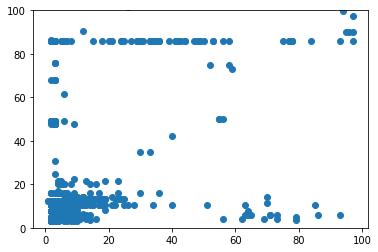

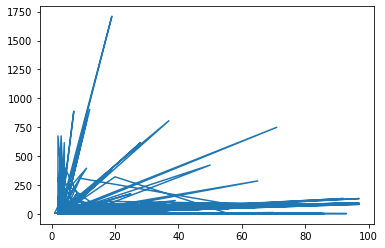

(3, 3.799003)
(3, 3.9512882)
(4, 3.8912787)
(4, 5.9695654)
(4, 5.9695654)
(3, 3.9512882)
(4, 5.9695654)
(3, 10.576936)
(3, 3.8912787)
(7, 6.9210734)
(10, 5.9695654)
(3, 3.9512882)
(4, 5.9695654)
(8, 10.576936)
(4, 5.9695654)
(2, 3.8912787)
(3, 4.0136075)
(3, 11.237248)
(4, 5.9695654)
(3, 4.28694)
(3, 5.9695654)
(3, 3.8323076)
(3, 10.576936)
(4, 5.9695654)
(4, 5.9695654)
(2, 11.237248)
(3, 30.863066)
(2, 3.8912787)
(4, 5.9695654)
(12, 13.398325)
(4, 5.9695654)
(8, 11.237248)
(2, 3.3669674)
(3, 10.576936)
(4, 5.9695654)
(8, 11.237248)
(4, 5.9695654)
(4, 5.9695654)
(3, 3.8912787)
(3, 3.8912787)
(2, 4.1693473)
(3, 10.576936)
(3, 3.3669674)
(3, 11.237248)
(2, 3.9512882)
(3, 3.9512882)
(4, 5.9695654)
(2, 3.9512882)
(3, 11.237248)
(4, 5.9695654)


In [332]:
metrics_and_predMin100(model_trained_aenc2[0],scaled_df_test, y_test)

In [343]:
list(zip(y_test, y_pred_org_test.flatten()))

[(3, 3.2032483),
 (651, 863.2547),
 (3, 3.1413937),
 (151, 208.78246),
 (4, 3.2255542),
 (1111, 17.822483),
 (542, 634.62085),
 (4, 4.1519017),
 (4, 4.1519017),
 (3, 3.1413937),
 (4, 4.1519017),
 (3, 8.837729),
 (1274, 1139.5093),
 (595, 634.62085),
 (3, 3.2255542),
 (935, 9.175508),
 (788, 863.2547),
 (7, 5.427267),
 (539, 505.78342),
 (10, 4.1519017),
 (169, 143.26532),
 (3, 3.1413937),
 (4, 4.1519017),
 (1158, 1139.5093),
 (2318, 1200.9733),
 (1165, 1139.5093),
 (1864, 1139.5093),
 (8, 8.837729),
 (1495, 1139.5093),
 (880, 862.4137),
 (4, 4.1519017),
 (735, 1139.5093),
 (959, 645.0959),
 (2, 3.2255542),
 (3, 3.0865343),
 (3, 9.175508),
 (4, 4.1519017),
 (3, 3.1072614),
 (3, 4.1519017),
 (518, 505.78342),
 (1362, 1200.9733),
 (629, 805.05096),
 (2008, 1139.5093),
 (3, 2.739449),
 (3, 8.837729),
 (1192, 873.12897),
 (863, 715.5036),
 (201, 126.91981),
 (2137, 763.7757),
 (4, 4.1519017),
 (726, 10.634957),
 (1264, 1139.5093),
 (4, 4.1519017),
 (2, 9.175508),
 (981, 1139.5093),
 (3, 26.

In [345]:
def metrics_and_predall(model, x_data, y_trueva):
    sub_y_true = y_trueva
    data = scaled_df_test.loc[sub_y_true.index]
    print("MSE ",MSE_data(model, data, sub_y_true))
    print("R2 ",r2score_data(model, data, sub_y_true))
    allv = print_predictions(model, data, sub_y_true)
    plt.scatter([a[0]for a in allv],[a[1] for a in allv])
    plt.ylim(0,120)
    plt.show()
    for val in allv[:50]:
        print(val)

MSE  605.1323406362227
R2  0.3495185686292518


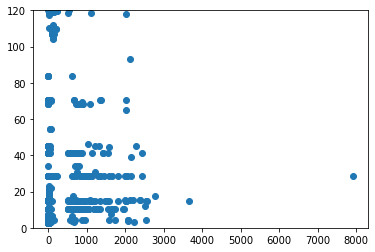

(3, 3.8031898)
(651, 808.3194)
(3, 4.3611436)
(151, 123.45421)
(4, 4.120001)
(1111, 118.39301)
(542, 500.0718)
(4, 6.496548)
(4, 6.496548)
(3, 4.3611436)
(4, 6.496548)
(3, 14.586047)
(1274, 723.38525)
(595, 500.0718)
(3, 4.120001)
(935, 10.48145)
(788, 808.3194)
(7, 7.799274)
(539, 341.3483)
(10, 6.496548)
(169, 297.78564)
(3, 4.3611436)
(4, 6.496548)
(1158, 723.38525)
(2318, 780.53186)
(1165, 723.38525)
(1864, 723.38525)
(8, 14.586047)
(1495, 723.38525)
(880, 698.1725)
(4, 6.496548)
(735, 723.38525)
(959, 279.37222)
(2, 4.120001)
(3, 4.1572576)
(3, 10.48145)
(4, 6.496548)
(3, 4.483995)
(3, 6.496548)
(518, 341.3483)
(1362, 780.53186)
(629, 594.02814)
(2008, 723.38525)
(3, 3.7974958)
(3, 14.586047)
(1192, 643.3906)
(863, 508.50613)
(201, 109.70803)
(2137, 559.8106)
(4, 6.496548)


In [346]:
metrics_and_predall(model_trained_aenc2[0],scaled_df_test, y_test)

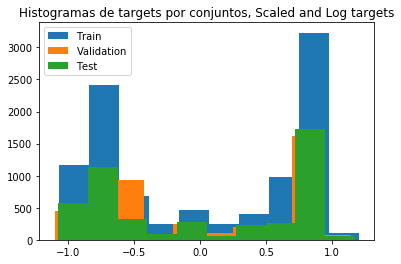

In [373]:
plt.title("Histogramas de targets por conjuntos, Scaled and Log targets")
plt.hist(model_trained_aenc2[0].predict(scaled_df_train.values),label="Train")
plt.hist(model_trained_aenc2[0].predict(scaled_df_val.values),label="Validation")
plt.hist(model_trained_aenc2[0].predict(scaled_df_test.values),label="Test")
plt.legend()
plt.show()

In [395]:
def load():
    model = Sequential()
    model.add(autoencoder.layers[0])
    model.add(autoencoder.layers[1])
    model.add(Dense(best_l1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(best_l2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(best_l3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    print(model.summary())
    model.load_weights('models_newdata/bestm_newdata.h5')

    return model

In [396]:
a = load()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 20)                700       
_________________________________________________________________
dense_296 (Dense)            (None, 260)               5460      
_________________________________________________________________
dropout_142 (Dropout)        (None, 260)               0         
_________________________________________________________________
dense_297 (Dense)            (None, 300)               78300     
_________________________________________________________________
dropout_143 (Dropout)        (None, 300)               0         
_________________________________________________________________
dense_298 (Dense)            (None, 240)               72240     
_________________________________________________________________
dense_299 (Dense)            (None, 1)               

In [398]:
#Prediction
y_pred_org_train = np.exp(scalery.inverse_transform(a.predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(a.predict(scaled_df_val.values).reshape(-1, 1)))
y_pred_org_test = np.exp(scalery.inverse_transform(a.predict(scaled_df_test.values).reshape(-1, 1)))

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_org_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_org_val))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_org_test))

print("RMSE Train", rmse_train)
print("RMSE VAL", rmse_val)
print("RMSE TEST", rmse_test)

print("R2 Train", r2_score(y_train, y_pred_org_train))
print("R2 VAL", r2_score(y_val, y_pred_org_val))
print("R2 TEST", r2_score(y_test, y_pred_org_test))

RMSE Train 662.898628017554
RMSE VAL 590.9488082986426
RMSE TEST 497.6051727588123
R2 Train 0.4413699852073706
R2 VAL 0.4753638304648662
R2 TEST 0.5601506561107393
